<a href="https://colab.research.google.com/github/rawatpremsingh999/DeepWeedsX/blob/master/DeepWeedX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Experiment on DeepWeedX dataset using MobileNetV3
url: https://www.kaggle.com/coreylammie/deepweedsx

The DeepWeedsX dataset consists of 17,508 unique 256x256 colour images in 9 classes. There are 15,007 training images and 2,501 test images. These images were collected in situ from eight rangeland environments across northern Australia.

All class label files consist of Comma Seperated Values (CSVs) detailing the label and species, for example: 20161207-111327-0.jpg, 0 denotes that 20161207-111327-0.jpg belongs to class 0 (Chinee Apple).

Class and species labels are as follows:

0- Chinee Apple <br>
1- Lantana <br>
2- Parkinsonia <br>
3- Parthenium <br>
4- Prickly Acacia <br>
5- Rubber Vine <br>
6- Siam Weed <br>
7- Snake Weed <br>
8- Other. <br>

All images are compressed in a single ZIP archive, and are labelled as per the class file labels.

**Download data from kaggle**

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

In [2]:
#changing the working directory
%cd /content/

#Check the present working directory using pwd command
!pwd

/content
/content


Note: <br>
(1) First, download json file from your kaggle profile. <br> 
**( Your Profile > Edit Profile > API section > Create New API Token)**. <br> 
It downloads a json file.

(2) upload json file in the collab directory *i.e. /content/*

In [3]:
!chmod 600 /content/kaggle.json

In [4]:
!kaggle datasets download -d coreylammie/deepweedsx

 98% 921M/943M [00:03<00:00, 253MB/s]
100% 943M/943M [00:04<00:00, 241MB/s]


In [5]:
# extract zip file
import zipfile

local_zip = '/content/deepweedsx.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/deepweedsx')
zip_ref.close()

**Import Necessary Libraries**

In [6]:
import pandas as pd
import random
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

**Read Train and Test CSV File**

In [7]:
training_path = '/content/deepweedsx/train_set_labels.csv'
train_df = shuffle(pd.read_csv(training_path))

testing_path = '/content/deepweedsx/test_set_labels.csv'
test_df = shuffle(pd.read_csv(testing_path))

In [8]:
train_df.shape, test_df.shape

((15007, 2), (2501, 2))

**Make Validation data from training data**

In [9]:
validation_df = train_df.sample(frac = 0.1)
train_df = train_df.drop(validation_df.index)
train_df.shape, validation_df.shape

((13506, 2), (1501, 2))

**All images directory**

In [10]:
# Directory with our image dataset
all_image_dir = os.path.join('/content/deepweedsx/DeepWeeds_Images_256')

In [11]:
image_names = os.listdir(all_image_dir)
print(image_names[:10])

['20171218-121357-3.jpg', '20180125-095419-2.jpg', '20180112-092725-2.jpg', '20170920-174414-1.jpg', '20170207-153756-0.jpg', '20180112-071922-2.jpg', '20180125-095811-1.jpg', '20170217-121035-0.jpg', '20161207-111555-0.jpg', '20180109-073013-2.jpg']


In [12]:
print('Total images:', len(os.listdir(all_image_dir)))

Total images: 17536


**Label Data and Explore**

In [13]:
train_df.head()

,Label,Species
12821,20180112-091818-1.jpg,8
915,20170811-105123-2.jpg,0
1169,20170715-103504-1.jpg,1
744,20170718-133552-2.jpg,0
5620,20171113-123524-3.jpg,6


In [14]:
# for training dataframe
species_name = ['Chinee Apple','Lantana','Parkinsonia','Parthenium','Prickly Acacia',
                'Rubber Vine','Siam Weed','Snake Weed','Other']

categories = []
for sp in train_df['Species']:
  categories.append(species_name[sp])
train_df['Categories'] = categories

# for validation dataframe
categories = []
for sp in validation_df['Species']:
  categories.append(species_name[sp])
validation_df['Categories'] = categories

# for Test dataframe
categories = []
for sp in test_df['Species']:
  categories.append(species_name[sp])
test_df['Categories'] = categories

In [15]:
train_df.head()

,Label,Species,Categories
12821,20180112-091818-1.jpg,8,Other
915,20170811-105123-2.jpg,0,Chinee Apple
1169,20170715-103504-1.jpg,1,Lantana
744,20170718-133552-2.jpg,0,Chinee Apple
5620,20171113-123524-3.jpg,6,Siam Weed


**Frequency of weeds**

In [16]:
categories_count = train_df['Categories'].value_counts().to_frame()
categories_count

,Categories
Other,7040
Chinee Apple,855
Siam Weed,828
Lantana,824
Prickly Acacia,816
Parkinsonia,792
Parthenium,791
Snake Weed,780
Rubber Vine,780


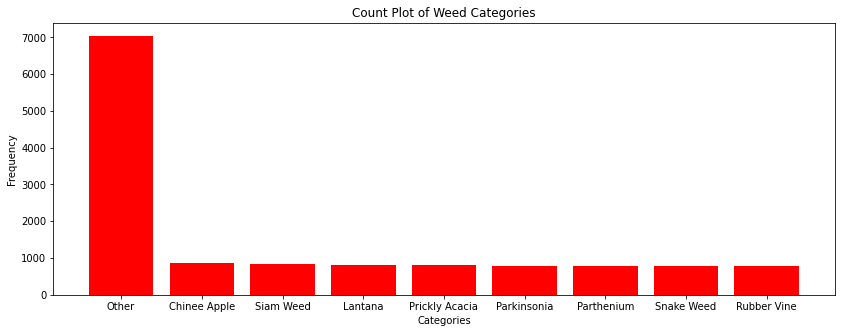

In [17]:
plt.figure(figsize=(14,5))

plt.bar(categories_count.index.to_list(),categories_count['Categories'],color='red')
plt.title('Count Plot of Weed Categories')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show()

**Visualization**

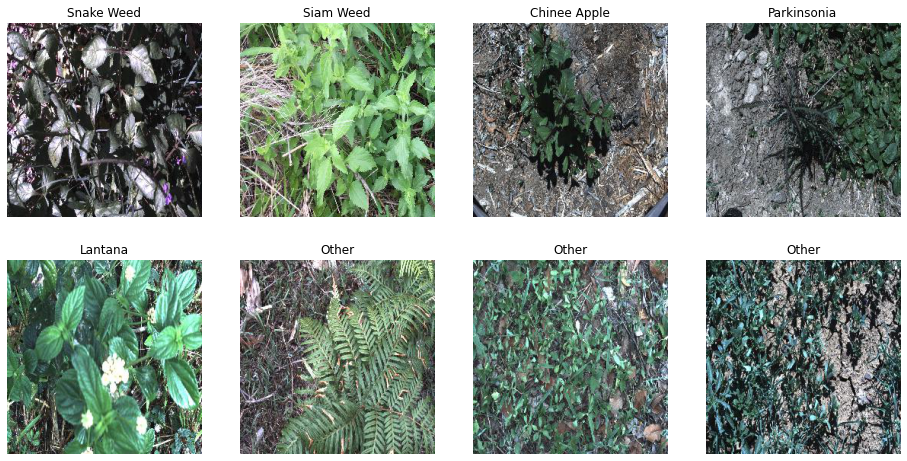

In [18]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(16, 8)

# Index for iterating over images
pic_index = random.choice(range(8,len(os.listdir(all_image_dir))-8))

merged_df = pd.concat([train_df,validation_df,test_df])

label_name = [merged_df.loc[merged_df['Label'] == i_name,'Categories'].tolist()[0] 
              for i_name in image_names[pic_index-8:pic_index]]

next_image_pix = [os.path.join(all_image_dir, fname) 
                for fname in image_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_image_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(2, 4, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title(label_name[i])

plt.show()

**Function for Data Generator**

In [19]:
def generate_data(train_df,validation_df,test_df,re_scale=None):
  image_path = "/content/deepweedsx/DeepWeeds_Images_256"

  train_datagen = ImageDataGenerator(rescale=re_scale)
  train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
                                                      directory = image_path,
                                                      x_col = "Label",
                                                      y_col = "Categories",
                                                      target_size = (224,224),
                                                      batch_size = 64,
                                                      class_mode = "categorical",
                                                      color_mode = "rgb"
                                                      )


  validation_datagen = ImageDataGenerator(rescale=re_scale)
  validation_generator = validation_datagen.flow_from_dataframe(dataframe=validation_df,
                                                                directory=image_path,
                                                                x_col = "Label",
                                                                y_col = "Categories",
                                                                target_size = (224,224),
                                                                batch_size = 64,
                                                                class_mode = "categorical",
                                                                color_mode = "rgb"
                                                                )


  test_datagen = ImageDataGenerator(rescale=re_scale)
  test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                    directory=image_path,
                                                    x_col = "Label",
                                                    y_col = "Categories",
                                                    target_size = (224,224),
                                                    batch_size = 64,
                                                    class_mode = "categorical",
                                                    color_mode = "rgb"
                                                    )
  
  return train_generator,validation_generator,test_generator

In [20]:
train_generator,validation_generator,test_generator = generate_data(train_df,validation_df,test_df,re_scale=1/255)

Found 13506 validated image filenames belonging to 9 classes.
Found 1501 validated image filenames belonging to 9 classes.
Found 2501 validated image filenames belonging to 9 classes.


**Data Augmentation**

In [21]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

**Build a small CNN model**

In [22]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 128*128 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The Third layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # flat
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    # 9 output neuron. It will contain a value from 0-8
    tf.keras.layers.Dense(9, activation='softmax')
])

**Summary of the model**

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)            

**Define Compilation**

In [24]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

**Train the model**

In [25]:
history = model.fit(
      train_generator,
      steps_per_epoch=16,
      batch_size = 16,
      epochs=20,
      verbose=0,
      validation_data=validation_generator,
      validation_steps=8)

# it will take approximate 3 minute to run 20 epoch with GPU enable

**Evaluation of model**

In [26]:
model.evaluate(test_generator)

40/40 [==============================] - 7s 160ms/step - loss: 1.3174 - accuracy: 0.5634


[1.317448377609253, 0.5633746385574341]

## Mobile Net V3 Large

**Use MobileNetV3 without using weights of imagenet**

In [27]:
base_model = MobileNetV3Large(input_shape=(224,224,3),
                              weights = None,
                              classes=9)

**Summary of the MobileNetV3Large**

In [28]:
# base_model.summary()

**Add augmentation layer before the mobilenetv3 and 1 layer for preprocess input according to mobile net v3**

In [29]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
outputs = base_model(x)
mobilenetv3 = tf.keras.Model(inputs,outputs)

In [30]:
mobilenetv3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3large (Functional (None, 9)                 4237961   
Total params: 4,237,961
Trainable params: 4,213,561
Non-trainable params: 24,400
_________________________________________________________________


**Define compilation**

In [31]:
mobilenetv3.compile(loss =tf.keras.losses.KLDivergence(),optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])

**Image data generator**

In [32]:
train_generator,validation_generator,test_generator = generate_data(train_df,validation_df,test_df,re_scale=None)

Found 13506 validated image filenames belonging to 9 classes.
Found 1501 validated image filenames belonging to 9 classes.
Found 2501 validated image filenames belonging to 9 classes.


**Compile model**

In [33]:
history = mobilenetv3.fit(train_generator,
                steps_per_epoch =4,
                 epochs=20,
                 batch_size=16,
                 verbose=1,
                 validation_data = validation_generator,
                 validation_steps= 4)

# it will take approx 45 seconds to run 20 epoch with GPU enable

Epoch 1/20
4/4 [==============================] - 10s 950ms/step - loss: 2.1574 - accuracy: 0.3318 - val_loss: 2.1925 - val_accuracy: 0.4648
Epoch 2/20
4/4 [==============================] - 2s 605ms/step - loss: 1.9013 - accuracy: 0.4578 - val_loss: 2.1871 - val_accuracy: 0.4883
Epoch 3/20
4/4 [==============================] - 2s 601ms/step - loss: 1.6402 - accuracy: 0.5391 - val_loss: 2.1814 - val_accuracy: 0.5039
Epoch 4/20
4/4 [==============================] - 2s 608ms/step - loss: 1.6300 - accuracy: 0.5167 - val_loss: 2.1785 - val_accuracy: 0.4727
Epoch 5/20
4/4 [==============================] - 2s 616ms/step - loss: 1.8784 - accuracy: 0.4391 - val_loss: 2.1741 - val_accuracy: 0.5117
Epoch 6/20
4/4 [==============================] - 2s 607ms/step - loss: 1.5465 - accuracy: 0.5474 - val_loss: 2.1768 - val_accuracy: 0.4492
Epoch 7/20
4/4 [==============================] - 2s 611ms/step - loss: 1.5682 - accuracy: 0.5260 - val_loss: 2.1726 - val_accuracy: 0.5273
Epoch 8/20
4/4 [===

In [34]:
mobilenetv3.evaluate(test_generator)

40/40 [==============================] - 6s 146ms/step - loss: 2.1610 - accuracy: 0.5202


[2.160951852798462, 0.5201919078826904]

### **MobileNetV3 with weights of imagenet and remove top layer**

In [35]:
base_mobilenetv3 = MobileNetV3Large(input_shape=(224,224,3),
                                    weights = 'imagenet',
                                    include_top = False)

17612800/17605208 [==============================] - 0s 0us/step


In [36]:
# base_mobilenetv3.summary()

**Freeze all the weights of MobileNetV3 Large**

In [37]:
base_mobilenetv3.trainable = False

In [38]:
# base_mobilenetv3.summary()

**Add top layer with 9 neurons after the MobileNetV3 Large**

In [60]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
x = base_mobilenetv3(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(9,activation='softmax')(x)
mobile_model = tf.keras.Model(inputs, outputs)

In [61]:
mobile_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
_________________________________________________________________
flatten_3 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 564489    
Total params: 4,790,921
Trainable params: 1,794,569
Non-trainable params: 2,996,352
_________________________________________________________________


**Define compilation of the model with KL divergence loss and Adam optimizer**

In [41]:
mobile_model.compile(loss = tf.keras.losses.KLDivergence(), optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

**Training of the model**

In [42]:
history = mobile_model.fit(train_generator,
                 steps_per_epoch =8,
                 epochs=50,
                 batch_size=16,
                 verbose=1,
                 validation_data = validation_generator,
                 validation_steps= 4)

Epoch 1/50
8/8 [==============================] - 6s 403ms/step - loss: 2.8679 - accuracy: 0.3554 - val_loss: 2.3831 - val_accuracy: 0.4375
Epoch 2/50
8/8 [==============================] - 2s 264ms/step - loss: 2.3620 - accuracy: 0.4465 - val_loss: 2.0502 - val_accuracy: 0.3906
Epoch 3/50
8/8 [==============================] - 2s 262ms/step - loss: 1.6762 - accuracy: 0.5127 - val_loss: 1.5278 - val_accuracy: 0.5859
Epoch 4/50
8/8 [==============================] - 2s 262ms/step - loss: 1.5609 - accuracy: 0.5229 - val_loss: 1.6069 - val_accuracy: 0.5898
Epoch 5/50
8/8 [==============================] - 2s 264ms/step - loss: 1.5676 - accuracy: 0.5929 - val_loss: 1.4706 - val_accuracy: 0.5859
Epoch 6/50
8/8 [==============================] - 2s 248ms/step - loss: 1.2619 - accuracy: 0.6232 - val_loss: 1.3379 - val_accuracy: 0.6328
Epoch 7/50
8/8 [==============================] - 2s 265ms/step - loss: 1.5328 - accuracy: 0.5819 - val_loss: 1.2940 - val_accuracy: 0.5977
Epoch 8/50
8/8 [====

In [43]:
mobile_model.evaluate(test_generator)

40/40 [==============================] - 6s 143ms/step - loss: 0.8792 - accuracy: 0.7381


[0.8792167901992798, 0.7381047606468201]

**Learning Curve**

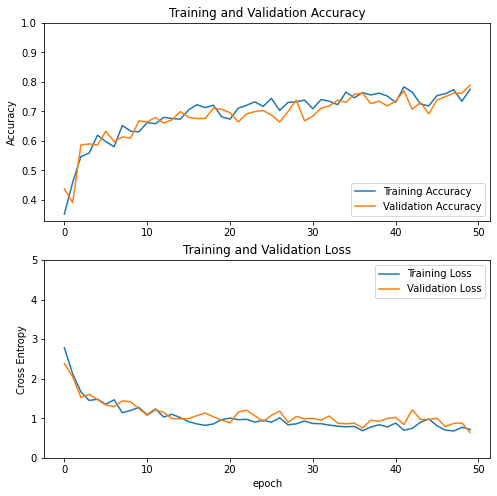

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### **Fine Tuning**

**Un-freeze the top layers of the mobile net model**

In [62]:
base_mobilenetv3.trainable = True

In [63]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_mobilenetv3.layers))

Number of layers in the base model:  276


**Fine-tune from this layer onwards**

In [64]:
fine_tune_at = 270

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_mobilenetv3.layers[:fine_tune_at]:
  layer.trainable =  False

In [65]:
mobile_model.compile(loss=tf.keras.losses.KLDivergence(),
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [66]:
mobile_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
_________________________________________________________________
flatten_3 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 564489    
Total params: 4,790,921
Trainable params: 1,794,569
Non-trainable params: 2,996,352
_________________________________________________________________


**Stopping Criteria**

In [68]:
class mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs = {}):
    if(logs.get('val_accuracy')>0.80):
      print("\nValidation Accuracy reached at greater than 80% so cancelling training!")
      self.model.stop_training = True

callback = mycallback()

**Traning**

In [69]:
hist = mobile_model.fit(train_generator,
                 steps_per_epoch = 8,
                 epochs=50,
                 batch_size=16,
                 verbose=1,
                 validation_data = validation_generator,
                 validation_steps= 4,
                 callbacks=[callback])

Epoch 1/50
8/8 [==============================] - 6s 402ms/step - loss: 2.6717 - accuracy: 0.3051 - val_loss: 1.7831 - val_accuracy: 0.4062
Epoch 2/50
8/8 [==============================] - 2s 258ms/step - loss: 1.6039 - accuracy: 0.4880 - val_loss: 1.4096 - val_accuracy: 0.5430
Epoch 3/50
8/8 [==============================] - 2s 261ms/step - loss: 1.3920 - accuracy: 0.5340 - val_loss: 1.4207 - val_accuracy: 0.5820
Epoch 4/50
8/8 [==============================] - 2s 259ms/step - loss: 1.2035 - accuracy: 0.6074 - val_loss: 1.3804 - val_accuracy: 0.5781
Epoch 5/50
8/8 [==============================] - 2s 257ms/step - loss: 1.1771 - accuracy: 0.6175 - val_loss: 1.1400 - val_accuracy: 0.6133
Epoch 6/50
8/8 [==============================] - 2s 260ms/step - loss: 0.9535 - accuracy: 0.6814 - val_loss: 1.2216 - val_accuracy: 0.6289
Epoch 7/50
8/8 [==============================] - 2s 258ms/step - loss: 1.1880 - accuracy: 0.6359 - val_loss: 0.9994 - val_accuracy: 0.6914
Epoch 8/50
8/8 [====

**Evaluate with test data**

In [70]:
mobile_model.evaluate(test_generator)

40/40 [==============================] - 6s 144ms/step - loss: 0.7275 - accuracy: 0.7709


[0.7274893522262573, 0.7708916664123535]

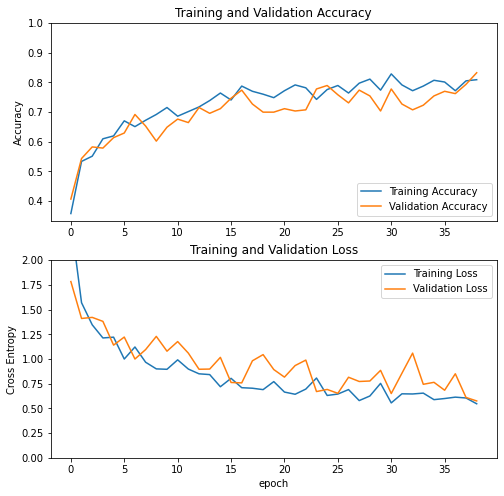

In [72]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Save model into google drive**

In [73]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [74]:
#mobile_model.save('/content/gdrive/MyDrive/Big Data Analytics/Kaggle Dataset/deepweedx_model.h5')